# Data Preparation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
import random
import re
from gensim.utils import tokenize
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/raw-data/lyrics-data.csv')
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [3]:
df_art = pd.read_csv('../data/raw-data/artists-data.csv')
df_art.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [4]:
df = df[df['language']=='en'].reset_index(drop=True)

## Genre

In [5]:
genres = []
for artist_id in tqdm(df['ALink']):    
    artist_row = df_art[df_art['Link']==artist_id].reset_index()
    try:
        genres_in_artist = artist_row['Genres'][0].split('; ')        
    except:
        genres_in_artist = []
    genres.append(genres_in_artist)

100%|██████████| 191814/191814 [02:48<00:00, 1137.90it/s]


In [6]:
df.drop(columns = ['ALink', 'SName', 'SLink', 'language'], inplace=True)
df.rename(columns={'Lyric': 'lyrics'}, inplace=True)

In [7]:
genres = pd.Series(genres)
# Convert nested list into one-hot-encoding
mlb = MultiLabelBinarizer()
genres_one_hot = pd.DataFrame(mlb.fit_transform(genres),
                    columns=mlb.classes_,
                    index=genres.index)
genres_one_hot.head()

,Axé,Black Music,Blues,Bossa Nova,COLETÂNEA,Chillout,Classic Rock,Clássico,Country,Dance,...,Soul Music,Surf Music,Tecnopop,Trance,Trap,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
genres_one_hot.sum().sort_values(ascending=False)[:10]

Rock           63717
Pop            33571
Pop/Rock       26360
Heavy Metal    21759
Hip Hop        20902
Indie          20134
Romântico      17947
Hard Rock      17250
Rap            17114
R&B            15581
dtype: int64

In [9]:
# Keep only the 8 most frequent genres (some of them will also be merged)
genres2keep = genres_one_hot.sum().sort_values(ascending=False)[:9].keys()

# Format labels
format_label = lambda s: s.lower().replace(' ', '-').replace('/', '-')

genres_one_hot = genres_one_hot[genres2keep]
genres_one_hot.rename(columns = dict([(
    genre_label, format_label(genre_label)) 
    for genre_label in genres_one_hot.keys()]), inplace=True)

In [10]:
df = pd.concat([df, genres_one_hot], axis=1)

In [11]:
genre_labels = [label for label in df.keys() if label != 'lyrics']

# Remove lyrics that do not fit into the main genres
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [12]:
jaccard_similarity = lambda x, y: np.logical_and(x, y).sum() / np.logical_or(x, y).sum()

genre_pairs = list(combinations(genre_labels, 2))

genre_similarities = [jaccard_similarity(df[genre_pair[0]], df[genre_pair[1]]) 
    for genre_pair in genre_pairs]

sorted(list(zip(genre_pairs, genre_similarities)),
    reverse=True, key=lambda x: x[1])[:20]

[(('hip-hop', 'rap'), 0.5317297231959386),
 (('heavy-metal', 'hard-rock'), 0.29537756525204223),
 (('rock', 'hard-rock'), 0.2094735898661568),
 (('pop', 'pop-rock'), 0.20258854218922445),
 (('rock', 'heavy-metal'), 0.15670672296200064),
 (('pop', 'romântico'), 0.13970311704975333),
 (('rock', 'pop-rock'), 0.13782431852057703),
 (('pop-rock', 'romântico'), 0.10936678434612784),
 (('rock', 'indie'), 0.10295433021151215),
 (('pop', 'hip-hop'), 0.058550330353672755),
 (('rock', 'romântico'), 0.0391540585593037),
 (('pop-rock', 'indie'), 0.03575486199291586),
 (('pop', 'rap'), 0.03301742586365026),
 (('pop', 'indie'), 0.02956118321415563),
 (('rock', 'pop'), 0.029502645502645503),
 (('indie', 'romântico'), 0.029299672946455118),
 (('pop-rock', 'hard-rock'), 0.012772875058058523),
 (('rock', 'hip-hop'), 0.007644950403086559),
 (('indie', 'hard-rock'), 0.007030681787571048),
 (('romântico', 'hard-rock'), 0.005513655582219175)]

In [13]:
# Merge together rap and hip hop
df['rap'] = np.logical_or(df['rap'], df['hip-hop']).replace({True: 1, False: 0})
# Drop columns
df.drop(columns=['romântico'], inplace=True)
df.drop(columns=['hip-hop'], inplace=True)
# Remove again lyrics that do not fit into the genres kept
genre_labels = [label for label in df.keys() if label != 'lyrics']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [14]:
df.reset_index(inplace=True, drop=True)
print(f'Number of lyrics {len(df)}')

Number of lyrics 143165


## Text Cleaning

In [15]:
# Duplicates are songs with multiple artists (e.g. a featuring)
# Remove duplicates having the same genre
print(f'Duplicates with the same genre: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
# Remove lyrics with different genres among duplicates:
print(f'Duplicates with different genres: {df.duplicated(subset="lyrics").sum()}')
df.drop_duplicates(subset="lyrics", keep=False, inplace=True)

Duplicates with the same genre: 646
Duplicates with different genres: 555


In [16]:
rand = random.choice(df['lyrics'])
rand

"Mother never told me\nthat the monsters weren't real\nsister never warned me 'bout your type\nbut i'm not scared of u\njust because you're different from all the rest\nI know just what 2 do\nwith an ogre in a dress\n\nChorus:\nangel, u can’t hide the little devil inside,\nangel, u’ve lost your pride 2 the devil inside,\nangel, u can’t lose with the devil by your side,\nangel, u can’t choose between the devil in your mind\n\nfather says he remembers meeting 1 of your kind\nbrother says with shame he went down on u\ny don't u see the shame of the ways u wanna bring ‘em down,\nthis so called fantasy, shatters everyone, everything around"

In [17]:
def clean_text(lyrics):
    lyrics = re.sub(r'\((.+?)?\)', '', lyrics)
    lyrics = re.sub(r'\[(.+?)?\]', '', lyrics)
    lyrics = re.sub(r'\{(.+?)?\}', '', lyrics)
    lyrics = re.sub(r'\n+', '\n', lyrics)
    lyrics = re.sub(r'^[^a-zA-Z]+$', '', lyrics, flags=re.MULTILINE)
    return lyrics

In [18]:
rand = random.choice(df['lyrics'])
clean_text(rand)

"I'll do anything you want me to\nDo\nI'm getting off because I'm being used\nBy you\nYou could do anything you wanted to\nDo\nYou could do anything you wanted to\nOoh, get up get ready\nOoh, get up be ready\nOoh, get up get ready\nGet ready\nGet ready\nFor a heart attack\nA heart attack\nIt's a heart attack\nHeart attack\nCan't wait my turn; my fear is looping\nMy thoughts get lost; the air is putrid\nYou can do anything you wanna do\nDo\nYou can do anything you wanna do\nOoh, get up get ready\nOoh, get up be ready\nOoh, get up get ready\nGet ready\nGet ready\nOoh, get up get ready\nOoh, get up be ready\nOoh, get up get ready\nGet ready\nGet ready\nFor a heart attack\nA heart attack\nIt's a heart attack\nHeart attack"

In [19]:
df['lyrics'] = [clean_text(lyrics) for lyrics in tqdm(df['lyrics'])]

100%|██████████| 141445/141445 [00:06<00:00, 22955.90it/s]


In [20]:
# Split lyrics in verses consider \n as sep, filter empty element in list (it's the result of '\n\n' or spaces)
df['lyrics'] = list(map(lambda x: [verse for verse in x.split('\n') if verse.strip()], df['lyrics']))

In [21]:
# Count number of verses
df['verses'] = df['lyrics'].apply(len)

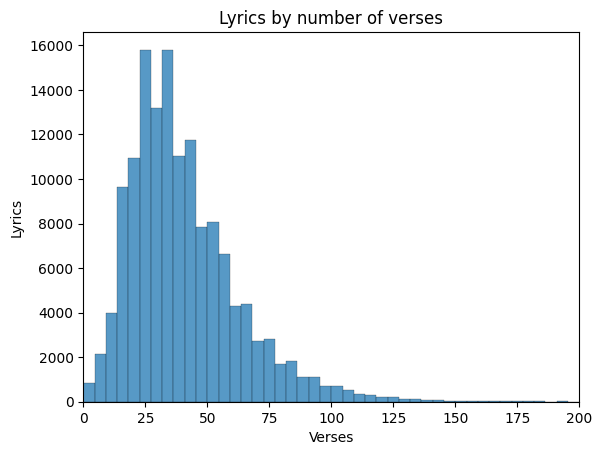

In [22]:
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=200)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
# There seems to be outliers
ax.set_xlim([0, 200])
plt.show()

In [23]:
df = df[df['verses']>20]

In [24]:
print(f'Number of lyrics {len(df)}')

Number of lyrics 119441


## Genre Label Filtering

In [25]:
# Get unique labels and compute value counts
df[df[genre_labels].sum(axis=1) == 1][genre_labels].sum(axis=0)

rock           19928
pop            15989
pop-rock        5151
heavy-metal     6201
indie           6737
hard-rock       1186
rap            19053
dtype: int64

In [26]:
# Drop songs with multiple genres
df.drop(df[df[genre_labels].sum(axis=1) > 1].index, inplace=True)
# Keep only rock, pop and rap lyrics:
# 1) Remove columns
df.drop(columns=['pop-rock','heavy-metal','indie','hard-rock'], inplace=True)
# 2) Remove rows
genre_labels = ['rock','pop','rap']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [27]:
# Map again dummy variables to labels
df['genre'] = df[['rock', 'pop', 'rap']].apply(lambda x: 'rock' if x[0] == 1 else ('pop' if x[1] == 1 else ('rap' if x[2] == 1 else None)), axis=1)

# Drop dummy variables
df = df.drop(columns=['rock', 'pop', 'rap'])

df.head()

,lyrics,verses,genre
0,"[I feel so unsure, As I take your hand and lea...",47,pop
1,"[Don't let them fool, ya, Or even try to schoo...",28,pop
2,"[Baby, let's cruise, away from here, Don't be ...",26,pop
3,"[Know it sounds funny, But, I just can't stand...",31,pop
4,"[You've got that look again, The one I hoped I...",35,pop


In [28]:
df['genre'].value_counts()

rock    19928
rap     19053
pop     15989
Name: genre, dtype: int64

## Outlier Detection

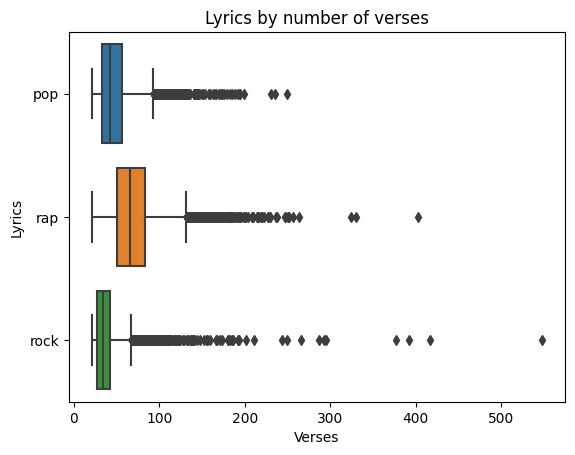

In [29]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x='verses', y='genre')
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
plt.show()

In [30]:
# Compute the IQR for each genre
grouped = df.groupby('genre')
# Compute IQR for each group
iqr = grouped.apply(lambda x: x['verses'].quantile(0.75) - x['verses'].quantile(0.25))
# Compute upper bounds for each group
upper_bound = grouped.apply(lambda x: x['verses'].quantile(0.75) + 1.5 * iqr[x.name])
# Reset the index of the upper_bound series to match the labels of the grouped DataFrame
upper_bound = upper_bound
# Mark outliers
df['outlier'] = np.where(df['verses'] > upper_bound[df['genre']].values, True, False)
# Get the index values of the outlier rows
outlier_index = df[df['outlier'] == True].index


In [31]:
upper_bound

genre
pop      93.0
rap     131.0
rock     67.0
dtype: float64

In [32]:
print(len(outlier_index))

1474


In [33]:
# Drop the outlier rows from the DataFrame
df = df.drop(outlier_index)

In [34]:
df['genre'].value_counts()

rock    19259
rap     18611
pop     15626
Name: genre, dtype: int64

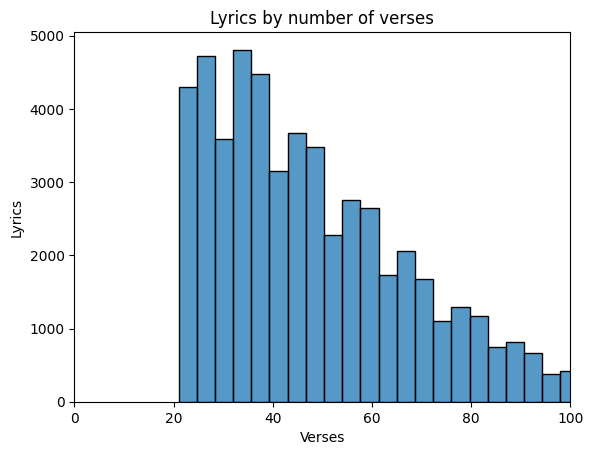

In [35]:
# Plot distribution
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=30)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
ax.set_xlim([0, 100])
plt.show()

In [36]:
lyrics_by_verse = zip(list(df['lyrics']),list(df['genre']),list(df.index))

verses_by_genre = [(verse, genre, index) for lyrics, genre, index in lyrics_by_verse for verse in lyrics]

df_verses = pd.DataFrame(verses_by_genre, columns=['verse','genre','index'])

df_verses.head()

,verse,genre,index
0,I feel so unsure,pop,0
1,As I take your hand and lead you to the dance ...,pop,0
2,"As the music dies, something in your eyes",pop,0
3,Calls to mind a silver screen,pop,0
4,And all those sad goodbyes,pop,0


In [37]:
df_verses['tokens'] = [len(list(tokenize(verse))) for verse in tqdm(df_verses['verse'])]

100%|██████████| 2640123/2640123 [00:16<00:00, 163228.38it/s]


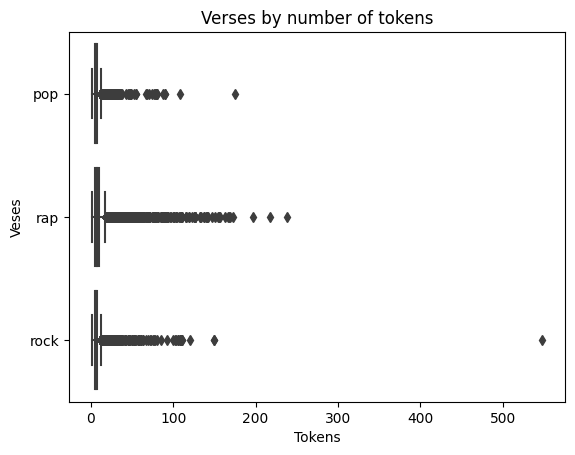

In [38]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df_verses, x='tokens', y='genre')
ax.set_xlabel('Tokens')
ax.set_ylabel('Veses')
ax.set_title('Verses by number of tokens')
plt.show()

In [39]:
df['lyrics'][df_verses[(df_verses['genre']=='rock') & (df_verses['tokens']>500)]['index']].values

array([list(['I wait for my true love, but she never came', 'I cry for my true love, but she never came', 'I leave this world never knowing who she was, departing all alone..', "I'd just like to speak for a second and say that, hum.. I just encourage everybody who hears this album to look towards Christ and not towards people, because people allow you to fall away, people aren't perfect. Theres only one person thats perfect and thats Christ. And I see people every day who are looking at Christ and blow Christ off because something that someone else has failed on. And its just not worth it, Christ has blessed me and every other member of this band more than any other way that I can imagine, or be spoken. Just the way everything worked out tonight was just beautiful. I just pray for each and every one of you, we wouldn't sit here and we wouldn't do this unless we wouldn't put the time into it unless it was trying to touch you, trying to reach your life and I just ask please just give you

In [40]:
# Compute the IQR for each genre
grouped = df_verses.groupby('genre')
# Compute IQR for each group
iqr = grouped.apply(lambda x: x['tokens'].quantile(0.75) - x['tokens'].quantile(0.25))
# Compute upper bounds for each group
upper_bound = grouped.apply(lambda x: x['tokens'].quantile(0.75) + 3 * iqr[x.name])
# Reset the index of the upper_bound series to match the labels of the grouped DataFrame
upper_bound = upper_bound
# Mark outliers
df_verses['outlier'] = np.where(df_verses['tokens'] > upper_bound[df_verses['genre']].values, True, False)
# Get the index values of the outlier rows
outlier_index = df_verses[df_verses['outlier'] == True]['index'].unique()



In [41]:
upper_bound

genre
pop     17.0
rap     25.0
rock    17.0
dtype: float64

In [42]:
len(outlier_index)

1153

In [43]:
# Drop the outlier rows from the DataFrame
df = df.drop(outlier_index)

In [44]:
df['genre'].value_counts()

rock    18732
rap     18283
pop     15328
Name: genre, dtype: int64

In [45]:
df = df[df['genre']!='pop']

In [46]:
print(f'Number of lyrics {len(df)}')

Number of lyrics 37015


In [47]:
df.drop(columns=['outlier'])

df.reset_index(inplace=True, drop=True)
# Keep original index as id incase we want to retrieve samples in original df
df['id'] = df.index

In [48]:
df.drop(columns=['verses']).to_csv('../data/lyrics.csv', index=False)

## Classification and Evaluation Datasets

In [49]:
df_eval = df.groupby("genre").sample(n=50, weights='verses',random_state=0
).reset_index( 
).drop(columns=['verses'])

df_eval.to_csv('../data/evaluation/lyrics_eval.csv', index=False)

In [50]:
df.drop(columns=['verses'], inplace=True)

In [51]:
y = list(df['genre'])
X = list(zip(list(df['lyrics']),list(df['id'])))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [52]:
df_train = pd.DataFrame(X_train, columns=['lyrics','id'])
df_train['genre'] = y_train
df_train.shape

(29612, 3)

In [53]:
df_test = pd.DataFrame(X_test, columns=['lyrics','id'])
df_test['genre'] = y_test
df_test.shape

(7403, 3)

In [54]:
df_train.to_csv('../data/classification/lyrics_train.csv', index=False)
df_test.to_csv('../data/classification/lyrics_test.csv', index=False)

## Evaluation Dataset Preparation

In [55]:
import pandas as pd
import numpy as np
import random
import ast
from tqdm import tqdm
import nlpaug.augmenter.word as naw
from math import sqrt
from sklearn.model_selection import train_test_split

In [56]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [57]:
df.head()

,index,lyrics,genre,outlier,id
0,17253,"[""All i know when #i'm# with you"", 'My little...",rap,False,17253
1,24217,"[""Kells, you know i can't keep doing this, i g...",rap,False,24217
2,18238,"['Put on your booty shorts', 'Ooh, I really li...",rap,False,18238
3,17181,"['Fargo, get on some real yard shit', 'Come in...",rap,False,17181
4,14845,"['Hands up in the air', 'I just want the', 'I ...",rap,False,14845


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    100 non-null    int64 
 1   lyrics   100 non-null    object
 2   genre    100 non-null    object
 3   outlier  100 non-null    bool  
 4   id       100 non-null    int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 3.3+ KB


In [59]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))

In [60]:
eg_lyrics = random.choice(df['lyrics'])

In [61]:
aug = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")


In [62]:
def misalign_lyrics(lyrics, repetitions, repeat_verse):
    verses2repeat = random.sample(range(0, len(lyrics)), repetitions)
    misaligned_lyrics = []
    for idx, verse in enumerate(lyrics):
        if idx in verses2repeat:
            misaligned_lyrics.extend([verse] * repeat_verse)
        else:
            misaligned_lyrics.append(verse)
    return misaligned_lyrics

In [63]:
clf_test_ids = list(pd.read_csv('../data/classification/lyrics_test.csv')['id'])
evaluation_ids = list(df['id'])

idxs2remove = list(set(clf_test_ids + evaluation_ids))
all_lyrics = pd.read_csv('../data/lyrics.csv').drop(index=idxs2remove)['lyrics']
all_lyrics = list(map(lambda x: ast.literal_eval(x), all_lyrics))

In [64]:
eg_verse = random.choice(eg_lyrics)
print('Original verse:')
print(eg_verse)

print('Augmented:')
aug.augment(eg_verse)

Original verse:
you so bad when you call me for duty
Augmented:


['you so loud that authorities call me for duty']

In [65]:
eg_lyrics = random.choice(df['lyrics'])

eg_aug_lyrics = [aug.augment(verse)[0] for verse in tqdm(eg_lyrics)]
eg_aug_misl_lyrics = misalign_lyrics(eg_aug_lyrics, repetitions=round(sqrt(len(eg_lyrics))), repeat_verse=2)

eg_fake_lyrics = random.choice(all_lyrics)

print('ORIGINAL lyrics:')
print(eg_lyrics)
print()
print('AUGMENTED lyrics:')
print('Aligned:')
print(eg_aug_lyrics)
print()
print('Misaligned:')
print(eg_aug_misl_lyrics)
print()
print('RANDOM lyrics:')
print(eg_fake_lyrics)

100%|██████████| 52/52 [00:30<00:00,  1.71it/s]

ORIGINAL lyrics:
["Kells, you know i can't keep doing this, i got to say somehing", "You feel me, see i just kcan't keep living life confused, girl", "You gotta make a move, tell me something, 'cause i'm", 'First you wanna go then you wanna stay', 'And then you wanna talk about it baby', 'Put your bag down and pick your bag up', 'And then you just wal out on me baby', 'If loves were eyes, then i can see your future', "In what we're doing baby", "Girl i'm not trying to confuse", 'Just wanna spend my life with you baby', 'Girl please tell me where do we go from here', 'Girl, i wanna change your name to my name', 'And i know you feel the same way so', "Girls let's just go, get far away from here", 'Let it beat, let our hearts beat, take a deep breath', "Now baby hold on and girl don't let go", 'yeah, just keep holding on', "Babe, we'll walk through the storm together, oh yeah", 'Girl i promise you this love is forever', 'First you say you love me', "And then you say well, i don't know ", 

In [66]:
augment_many = lambda lyrics: [aug.augment(verse)[0] for verse in lyrics]

aug_lyrics = [augment_many(lyrics) for lyrics in tqdm(df['lyrics'])]
misl_aug_lyrics = [misalign_lyrics(aug_lyr, repetitions=round(sqrt(len(aug_lyr))), repeat_verse=random.choice([2,3])) for aug_lyr in tqdm(aug_lyrics)]

df['similar_lyrics'] = misl_aug_lyrics
df['random_lyrics'] = random.sample(all_lyrics, len(df['lyrics']))

100%|██████████| 100/100 [00:00<00:00, 10171.46it/s]


In [67]:
df.head()

,index,lyrics,genre,outlier,id,similar_lyrics,random_lyrics
0,17253,"[All i know when #i'm# with you, My little ho...",rap,False,17253,"[All y knew was #i'm# with that, My little re...","[The more you see of your love, The more you m..."
1,24217,"[Kells, you know i can't keep doing this, i go...",rap,False,24217,"[Kells, your know im can't resist doing it, i ...","[Oh God! Oh God! Ugh, 9-1-1 What's your emerge..."
2,18238,"[Put on your booty shorts, Ooh, I really like ...",rap,False,18238,"[Put on those booty kit, Ooh, I really like se...","[Verse One: Raekwon the Chef, Machine gun rap ..."
3,17181,"[Fargo, get on some real yard shit, Come in on...",rap,False,17181,"[Fargo, spilling over the real yard shit, Come...","[See you've got the new biography, Where did t..."
4,14845,"[Hands up in the air, I just want the, I just ...",rap,False,14845,"[Hands flung into the air, I just wanted to, I...","[More rest and sex is all a nigga needs, In a ..."


In [68]:
df.to_csv('../data/evaluation/lyrics_eval.csv', index=False)